In [1]:
import scanpy as sc
import anndata as ann
import scipy as sci
import pandas as pd
import os
import numpy as np
import seaborn as sns
import episcanpy.api as epi

/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
SCRNA_DIR = '../data/chen-2019/P0BrainCortex/rna/'
SCATAC_DIR = '../data/chen-2019/P0BrainCortex/atac/'
META_PATH = '../data/chen-2019/P0BrainCortex/P0BrainCortex.csv'

# MetaData

In [4]:
metadata = pd.read_csv(META_PATH, index_col=0)
metadata.head()

,Batch,Barcode,IdentChar
GGCAATGGCCCT,12A,GGCAATGGCCCT,IP_Eomes
GGAGTCCATGGT,12A,GGAGTCCATGGT,Ex4_Tenm3
GAATCCGTCCCA,12A,GAATCCGTCCCA,Ex4_Tenm3
GGGAAAGTATTG,12A,GGGAAAGTATTG,Ex45_Galntl6
GTCATCCTGAGA,12A,GTCATCCTGAGA,Ex4_Tenm3


# scRNA-seq Data

In [5]:
%%time
scrna = sc.read_10x_mtx(SCRNA_DIR, var_names='gene_symbols', cache=True)
scrna.obs = scrna.obs.join(metadata, how='left', sort=False)
scrna

CPU times: user 165 ms, sys: 12.1 ms, total: 177 ms
Wall time: 347 ms


AnnData object with n_obs × n_vars = 5081 × 19322
    obs: 'Batch', 'Barcode', 'IdentChar'
    var: 'gene_ids'

In [6]:
scrna.obs.head()

,Batch,Barcode,IdentChar
GGCAATGGCCCT,12A,GGCAATGGCCCT,IP_Eomes
GGAGTCCATGGT,12A,GGAGTCCATGGT,Ex4_Tenm3
GAATCCGTCCCA,12A,GAATCCGTCCCA,Ex4_Tenm3
GGGAAAGTATTG,12A,GGGAAAGTATTG,Ex45_Galntl6
GTCATCCTGAGA,12A,GTCATCCTGAGA,Ex4_Tenm3


In [7]:
scrna.var.head()

,gene_ids
0610005C13Rik,0610005C13Rik
0610007P14Rik,0610007P14Rik
0610009B22Rik,0610009B22Rik
0610009E02Rik,0610009E02Rik
0610009L18Rik,0610009L18Rik


## Data Cleaning

In [8]:
scrna.obs = scrna.obs.rename(columns={'IdentChar': 'cell_type'})

In [9]:
scrna.obs['Batch'] = scrna.obs['Batch'].astype('category')
scrna.obs['cell_type'] = scrna.obs['cell_type'].astype('category')

In [10]:
scrna.var = scrna.var.rename(columns={'gene_ids': 'gene_symbols'})

# Quality Control

In [11]:
scrna.var_names_make_unique()

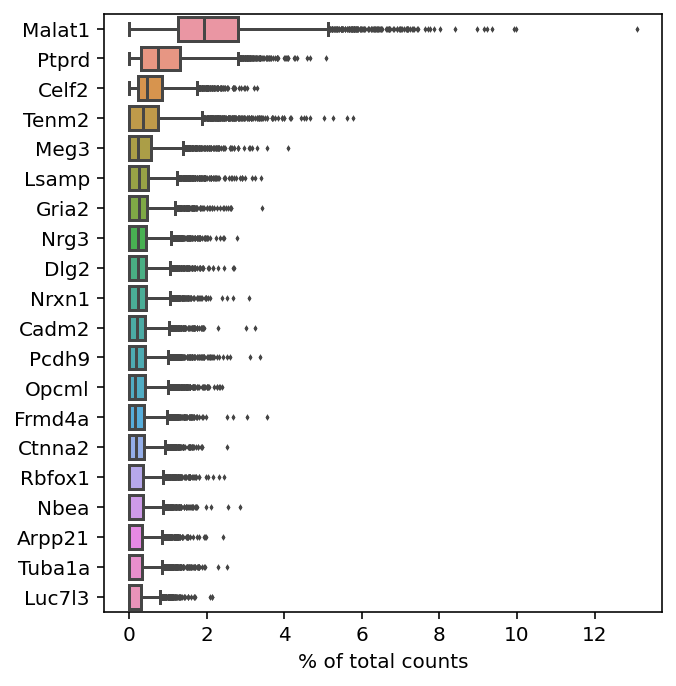

In [12]:
sc.pl.highest_expr_genes(scrna, n_top=20)

### Basic filtering

In [13]:
sc.pp.filter_cells(scrna, min_genes=1)
sc.pp.filter_genes(scrna, min_cells=1)
scrna

AnnData object with n_obs × n_vars = 5081 × 19322
    obs: 'Batch', 'Barcode', 'cell_type', 'n_genes'
    var: 'gene_symbols', 'n_cells'

## Qalculate QC metrics including Mitochondrial genes

In [14]:
scrna.var['mt'] = scrna.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(scrna, qc_vars=['mt'], percent_top=None, inplace=True)
scrna

AnnData object with n_obs × n_vars = 5081 × 19322
    obs: 'Batch', 'Barcode', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

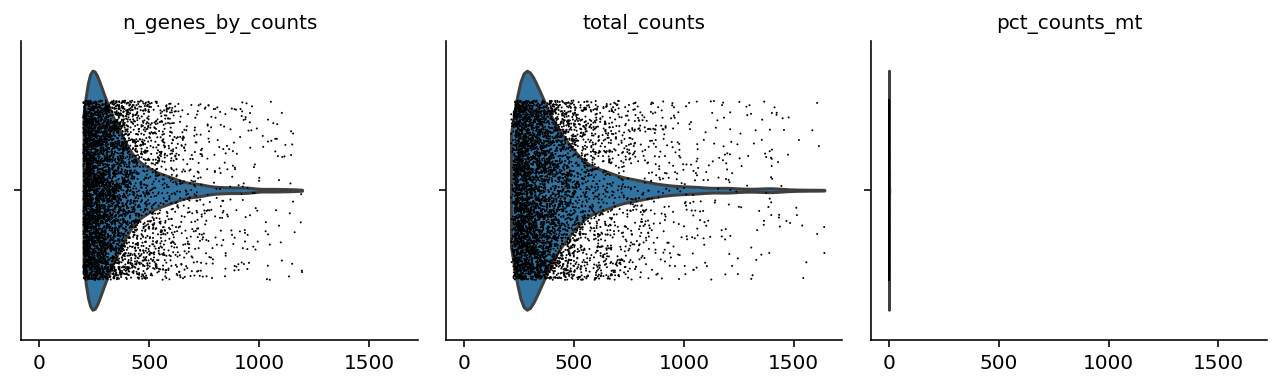

In [15]:
sc.pl.violin(scrna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.3, multi_panel=True)

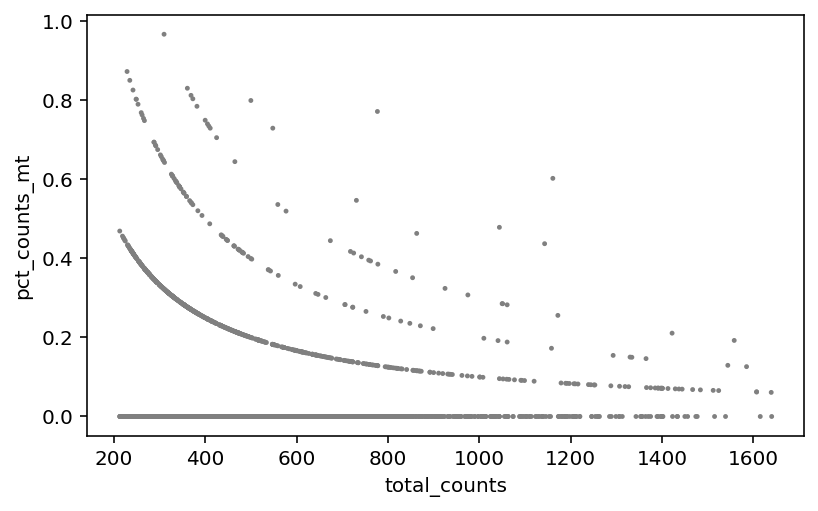

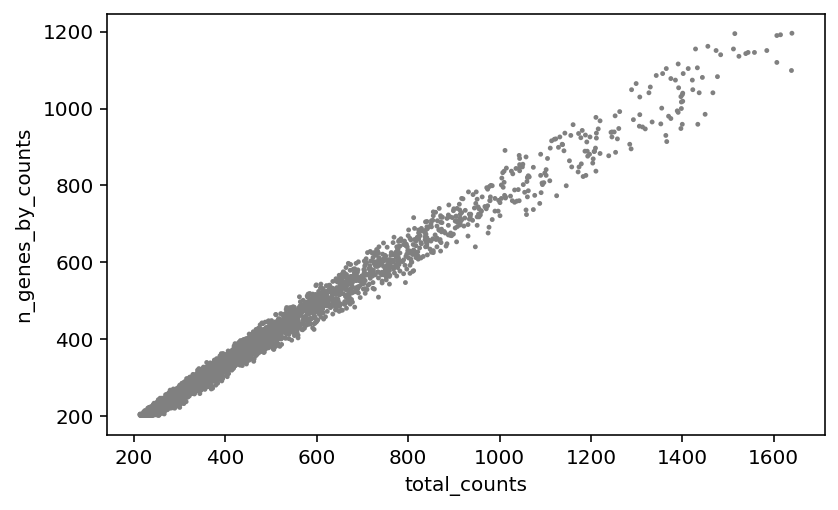

In [16]:
sc.pl.scatter(scrna, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(scrna, x='total_counts', y='n_genes_by_counts')

Filter out samples with high mitochondrial genes and highest number of genes:

In [17]:
sc.pp.filter_cells(scrna, min_genes=100)
sc.pp.filter_genes(scrna, min_cells=3)
scrna = scrna[scrna.obs.n_genes_by_counts < 800, :]
scrna = scrna[scrna.obs.pct_counts_mt < 0.6, :]
scrna

View of AnnData object with n_obs × n_vars = 4891 × 15028
    obs: 'Batch', 'Barcode', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [18]:
%time scrna.write(SCRNA_DIR + 'expressions-raw.h5ad')
scrnaraw = scrna.copy()

CPU times: user 242 ms, sys: 29.3 ms, total: 271 ms
Wall time: 500 ms


## Normalization

In [19]:
sc.pp.normalize_total(scrna, target_sum=1e4)
sc.pp.log1p(scrna)

## Filtering Highly Variable Genes

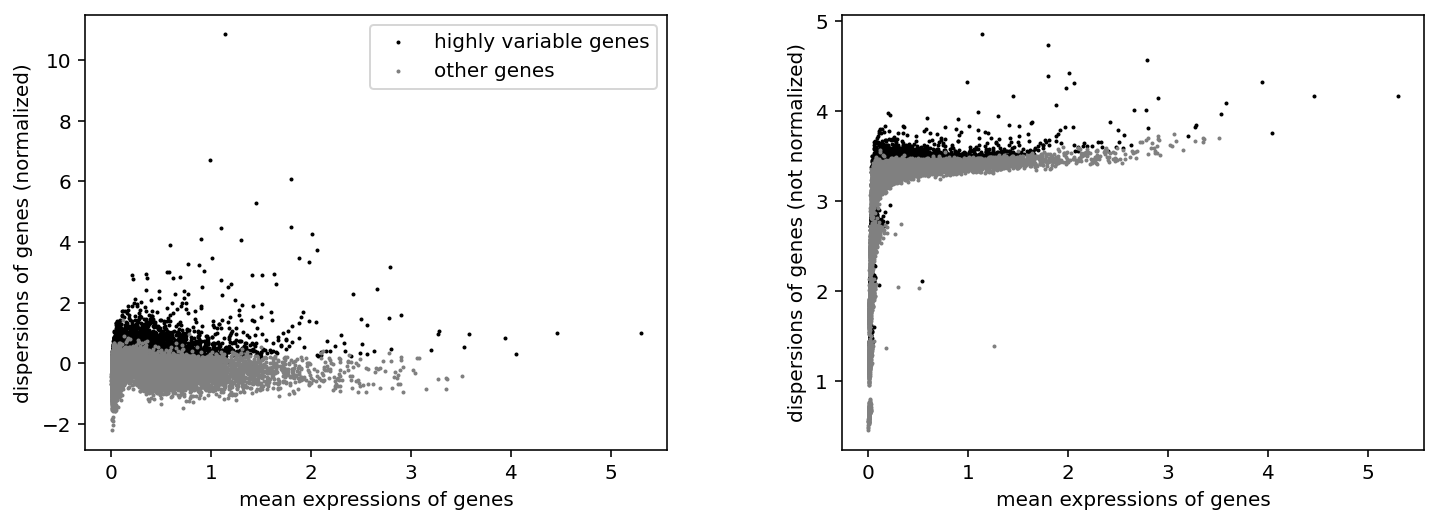

In [21]:
sc.pp.highly_variable_genes(scrna, n_top_genes=4000, batch_key='Batch')
sc.pl.highly_variable_genes(scrna)

In [22]:
scrna = scrna[:, scrna.var.highly_variable]
scrna

View of AnnData object with n_obs × n_vars = 4891 × 4000
    obs: 'Batch', 'Barcode', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p'

In [23]:
scrna.layers['count'] = scrnaraw[:, scrna.var.index].X.astype(np.uint8).copy()

## Visualization

In [24]:
sc.pp.neighbors(scrna)
sc.tl.umap(scrna)

         Falling back to preprocessing with `sc.pp.pca` and default params.


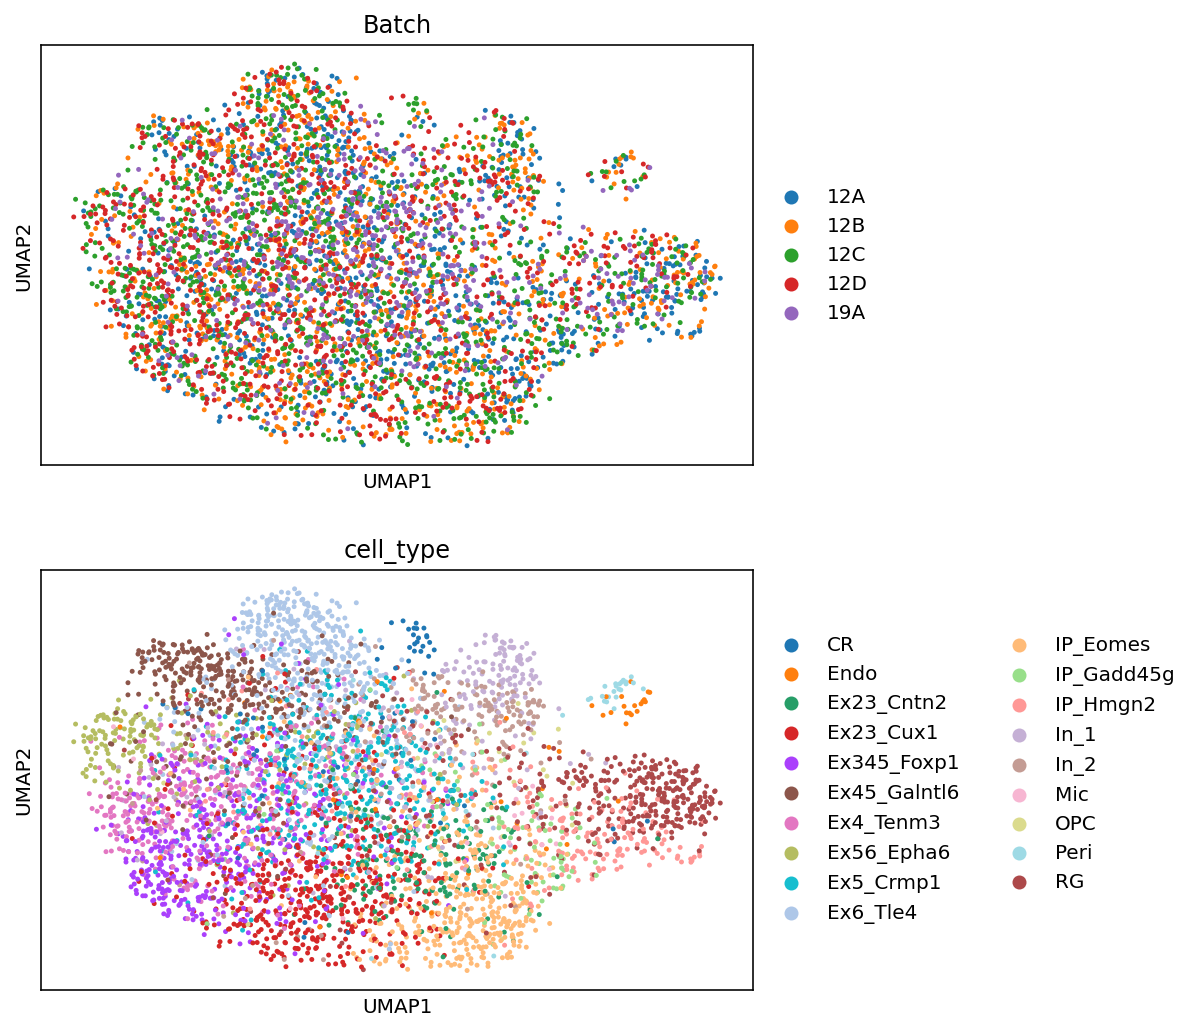

In [25]:
sc.pl.umap(scrna, color=['Batch', 'cell_type'], ncols=1)

---
# scATAC-seq Data

In [26]:
%%time
scatac = sc.read_10x_mtx(SCATAC_DIR, var_names='gene_symbols', cache=True)
scatac.obs = scatac.obs.join(metadata, how='left', sort=False)
scatac

CPU times: user 25.9 s, sys: 2.25 s, total: 28.2 s
Wall time: 36.6 s


AnnData object with n_obs × n_vars = 5081 × 229429
    obs: 'Batch', 'Barcode', 'IdentChar'
    var: 'gene_ids'

In [27]:
scatac.obs.head()

,Batch,Barcode,IdentChar
TGGAATTTTCTC,12D,TGGAATTTTCTC,CR
CCAACAAACGCG,12B,CCAACAAACGCG,CR
TGCGCATAGCCG,12B,TGCGCATAGCCG,CR
CTGTTTCCCACC,12B,CTGTTTCCCACC,CR
ACAGTCTACATG,12B,ACAGTCTACATG,CR


In [28]:
scatac.var.head()

,gene_ids
chr1:3012650-3012823,chr1:3012650-3012823
chr1:3012853-3013002,chr1:3012853-3013002
chr1:3030589-3030826,chr1:3030589-3030826
chr1:3071552-3071701,chr1:3071552-3071701
chr1:3078770-3078919,chr1:3078770-3078919


## Data Cleaning

In [29]:
scatac.obs = scatac.obs.rename(columns={'IdentChar': 'cell_type'})

In [30]:
scatac.obs['Batch'] = scatac.obs['Batch'].astype('category')
scatac.obs['cell_type'] = scatac.obs['cell_type'].astype('category')

## Quality Control

### Basic filtering

In [31]:
epi.pp.filter_features(scatac, min_cells=1)
epi.pp.filter_cells(scatac, min_features=1)
scatac

AnnData object with n_obs × n_vars = 5081 × 229429
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells'

### Binarization

In [32]:
%time epi.pp.binarize(scatac)
scatac

CPU times: user 1.05 s, sys: 836 ms, total: 1.88 s
Wall time: 3.31 s


AnnData object with n_obs × n_vars = 5081 × 229429
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells'

### Filter low quality cells and peaks

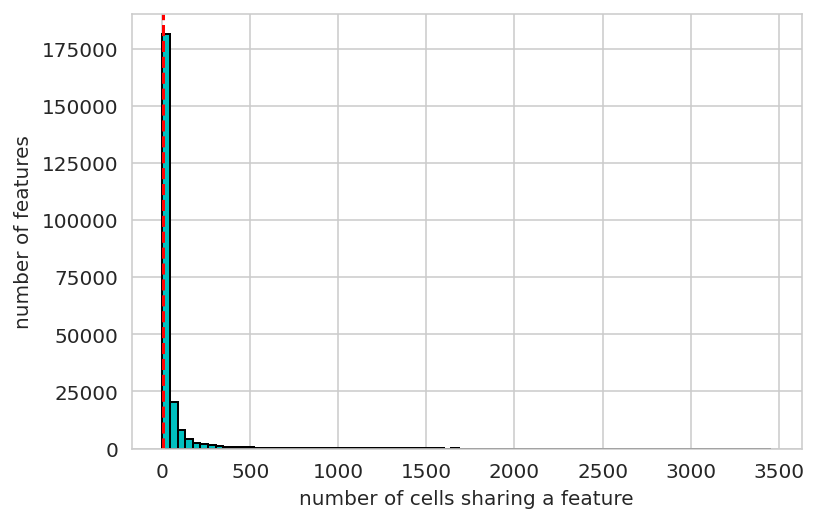

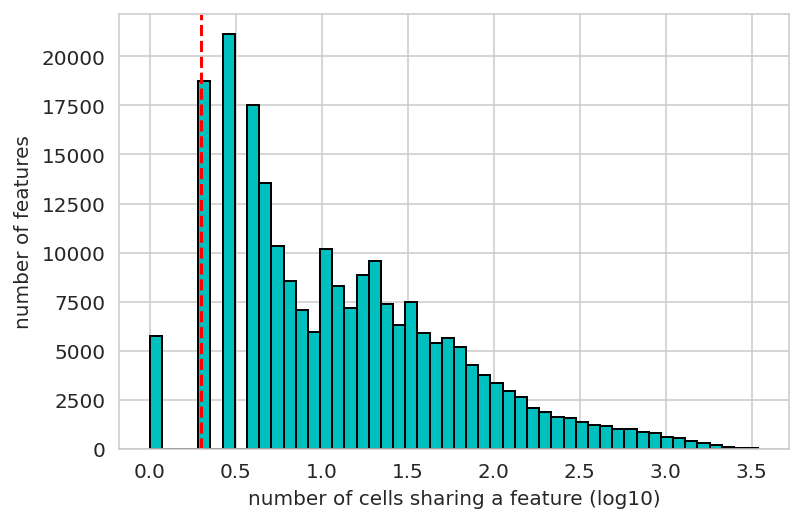

In [37]:
epi.pp.coverage_features(scatac, binary=True, log=False, bins=50, threshold=2)
epi.pp.coverage_features(scatac, binary=True, log=10, bins=50, threshold=2)

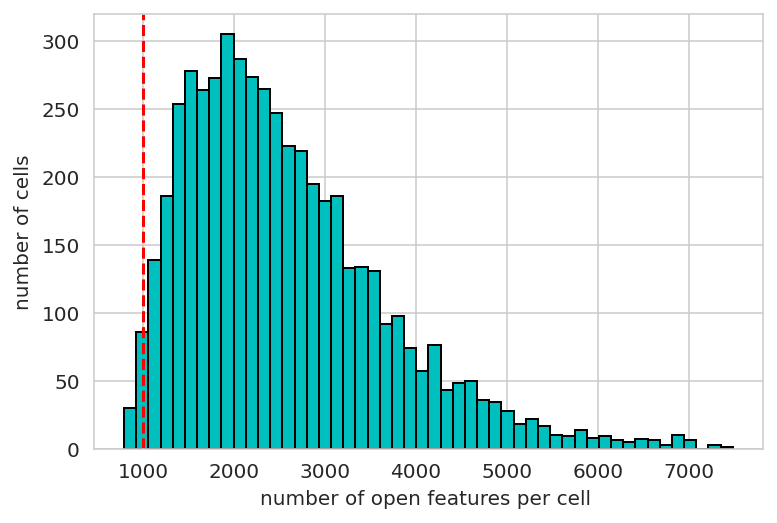

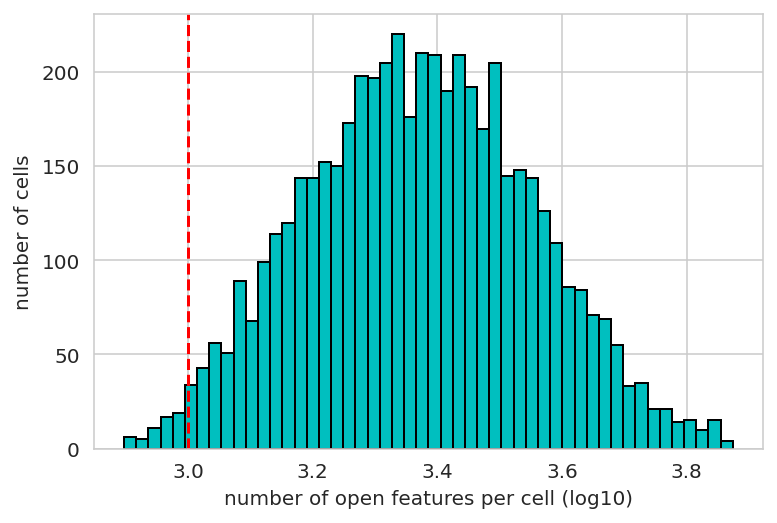

In [39]:
epi.pp.coverage_cells(scatac, binary=True, log=False, bins=50, threshold=1000)
epi.pp.coverage_cells(scatac, binary=True, log=10, bins=50, threshold=1000)

In [40]:
epi.pp.filter_cells(scatac, min_features=1000)
epi.pp.filter_features(scatac, min_cells=2)
scatac

AnnData object with n_obs × n_vars = 5014 × 223480
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells', 'commonness'

Filtering cells with high open peaks and peaks with high number of cells:

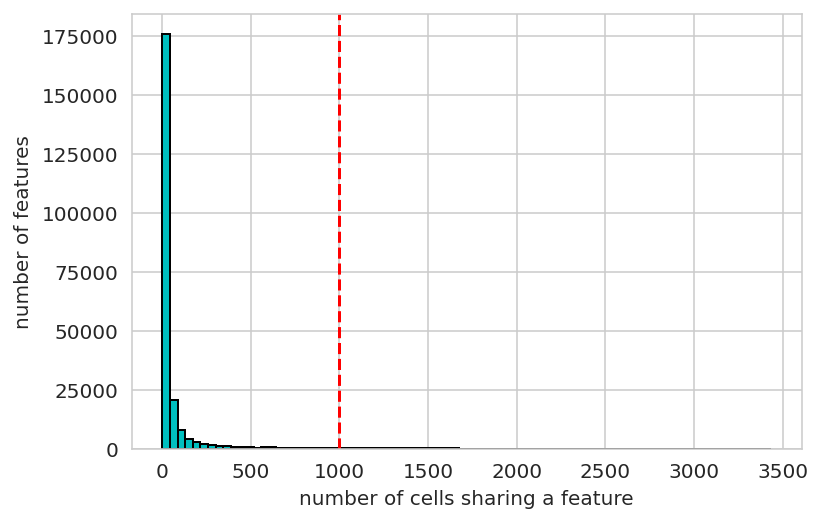

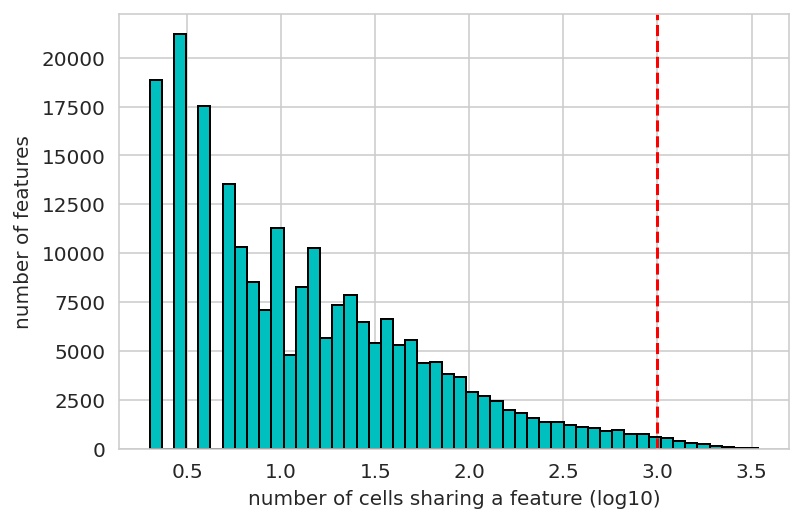

In [43]:
epi.pp.coverage_features(scatac, binary=True, log=False, bins=50, threshold=1000)
epi.pp.coverage_features(scatac, binary=True, log=True, bins=50, threshold=1000)

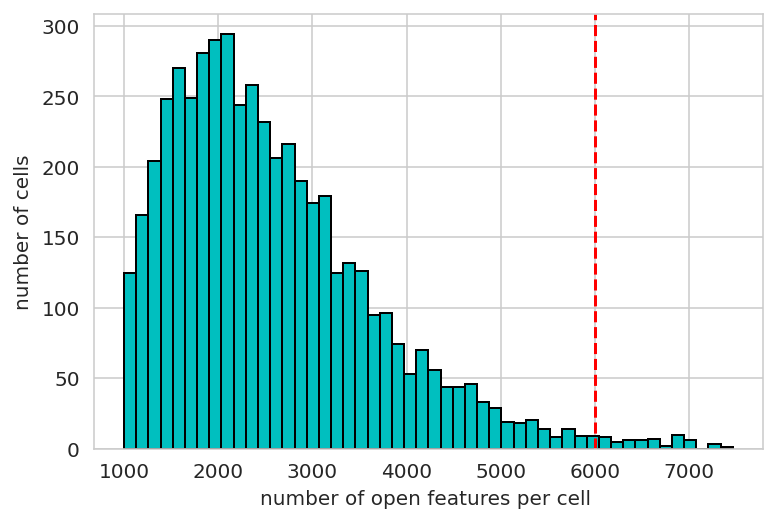

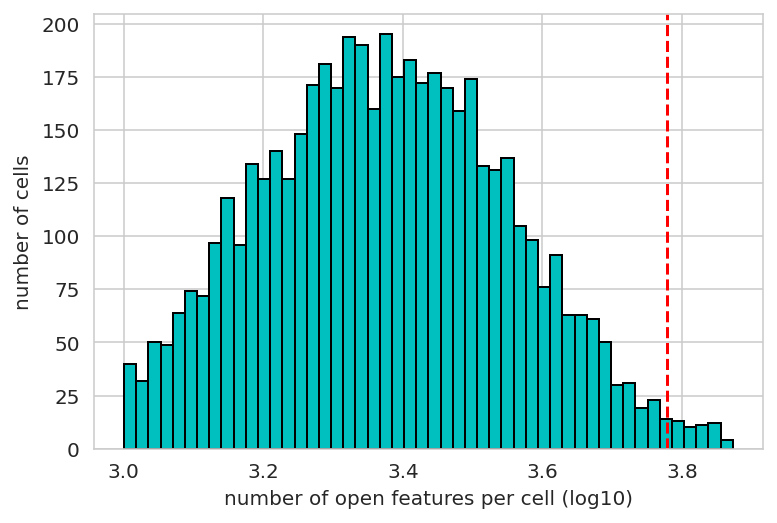

In [46]:
epi.pp.coverage_cells(scatac, binary=True, log=False, bins=50, threshold=6000)
epi.pp.coverage_cells(scatac, binary=True, log=True, bins=50, threshold=6000)

In [47]:
epi.pp.filter_cells(scatac, max_features=6000)
epi.pp.filter_features(scatac, max_cells=1000)
scatac

AnnData object with n_obs × n_vars = 4957 × 221699
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells', 'commonness'

In [48]:
scatac.obs['nb_features'].describe()

count    4957.000000
mean     2532.931007
std      1003.002572
min      1001.000000
25%      1766.000000
50%      2348.000000
75%      3122.000000
max      6000.000000
Name: nb_features, dtype: float64

In [49]:
scatac.var['commonness'].describe()

count    221699.000000
mean         46.553489
std         111.180124
min           2.000000
25%           4.000000
50%          11.000000
75%          35.000000
max        1032.000000
Name: commonness, dtype: float64

In [50]:
scatac.var['commonness'].median()

11.0

In [51]:
scatac = scatac[:, scatac.var['commonness'] > scatac.var['commonness'].median()]
scatac

View of AnnData object with n_obs × n_vars = 4957 × 108606
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells', 'commonness'

## Selecting variable peaks

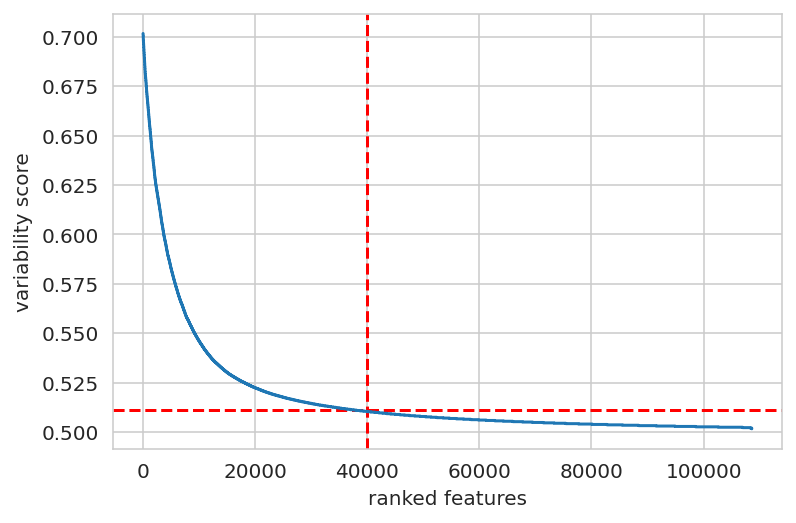

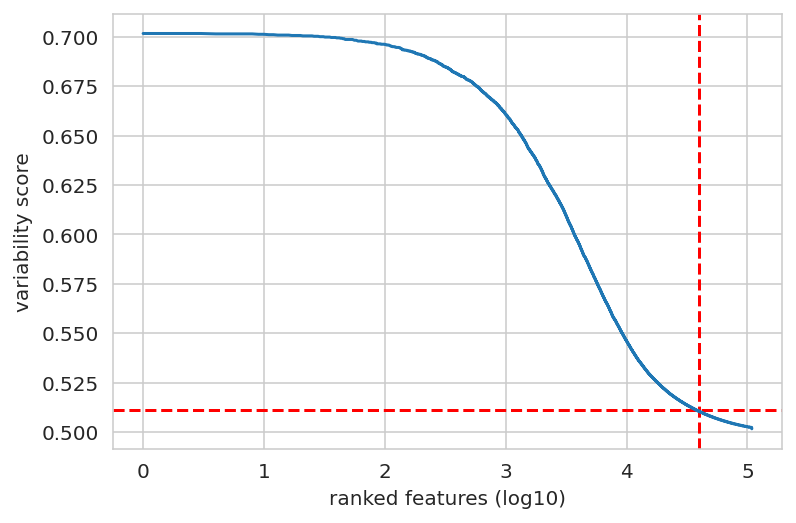

In [54]:
min_score_value = 0.511
nb_feature_selected = 40000
epi.pl.variability_features(scatac, log=None, min_score=min_score_value, nb_features=nb_feature_selected)
epi.pl.variability_features(scatac, log='log10', min_score=min_score_value, nb_features=nb_feature_selected)

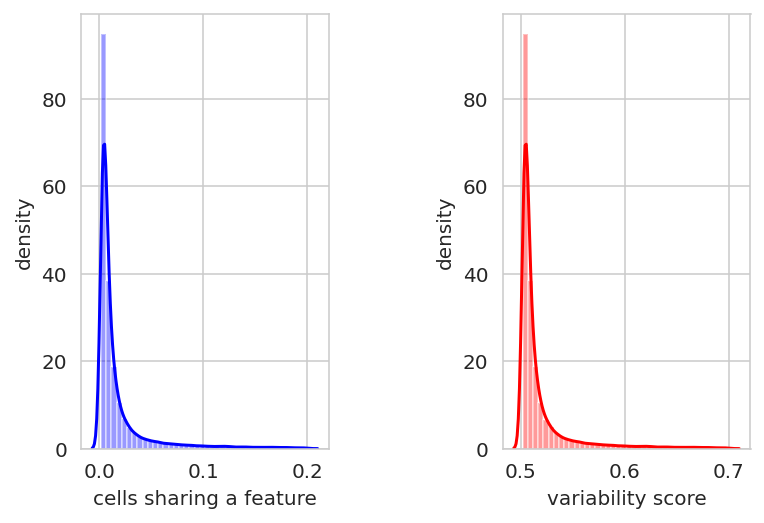

CPU times: user 2.36 s, sys: 998 ms, total: 3.36 s
Wall time: 4.59 s


In [55]:
%time epi.pp.select_var_feature(scatac, nb_features=nb_feature_selected)

In [56]:
scatac

AnnData object with n_obs × n_vars = 4957 × 40623
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [57]:
scatac.layers['binary'] = scatac.X.astype(np.uint8).copy()

## Normalization

In [58]:
epi.pp.normalize_total(scatac, target_sum=1e4)
epi.pp.log1p(scatac)

## Visualization

### Running UMAP

In [59]:
sc.pp.neighbors(scatac)
sc.tl.umap(scatac)

         Falling back to preprocessing with `sc.pp.pca` and default params.


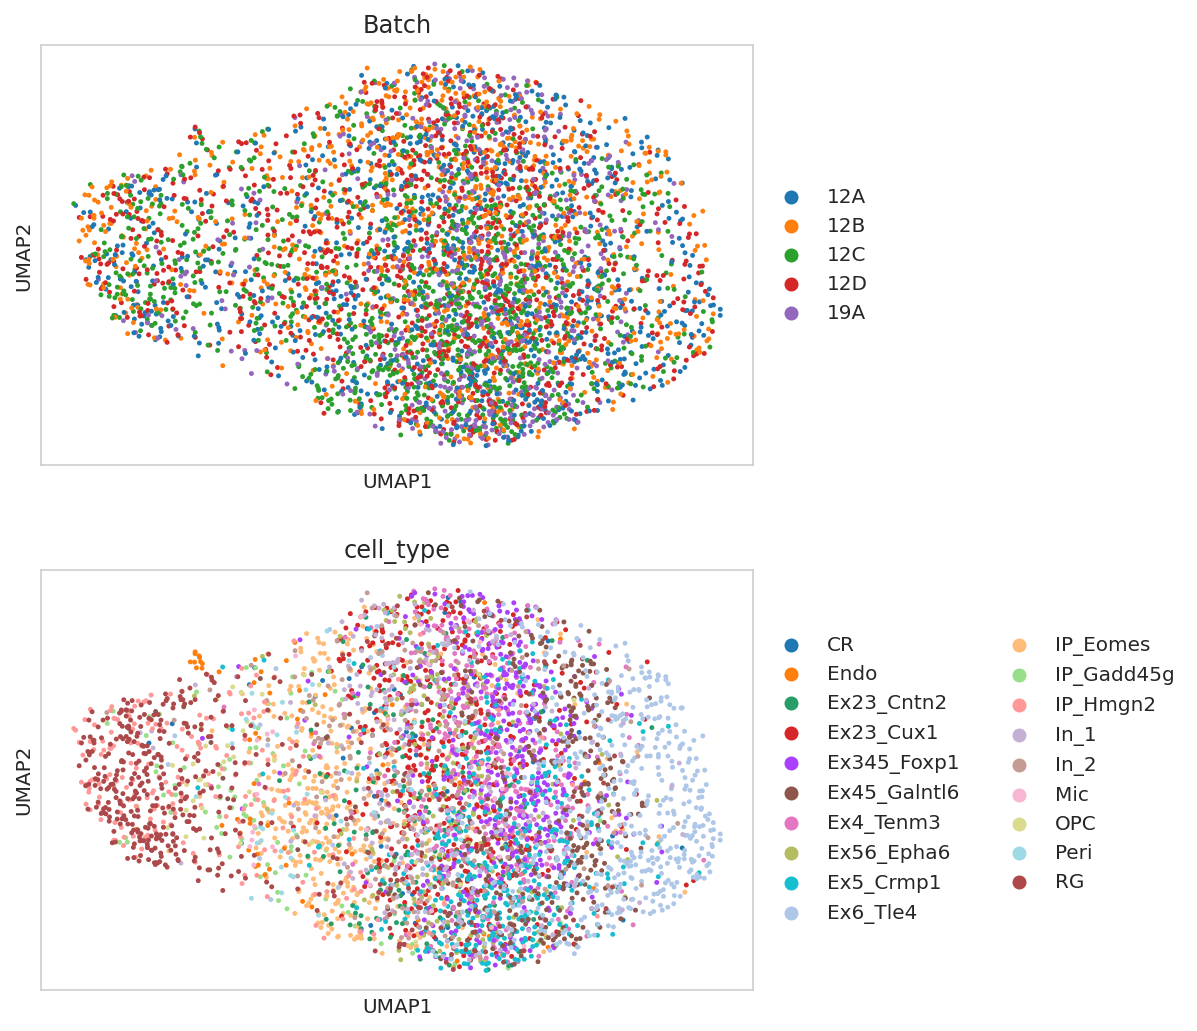

In [60]:
sc.pl.umap(scatac, color=['Batch', 'cell_type'], ncols=1)

---
# Save the results

### Find common paired samples

In [61]:
com_index = set(scrna.obs.index) & set(scatac.obs.index)
scrna = scrna[scrna.obs.index.isin(com_index)]
scatac = scatac[scatac.obs.index.isin(com_index)]
print(scrna.shape, scatac.shape)

(4793, 4000) (4793, 40623)


In [62]:
%time scrna.write(SCRNA_DIR + 'expressions.h5ad')

CPU times: user 185 ms, sys: 14.5 ms, total: 200 ms
Wall time: 314 ms


In [63]:
%time scatac.write_h5ad(SCATAC_DIR + 'peaks.h5ad')

CPU times: user 1.04 s, sys: 73.4 ms, total: 1.11 s
Wall time: 1.73 s
